In [1]:
# Time-series analysis - March 2024 - with Tractor-Sales.csv data

In [2]:
# import needed common libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt 

In [3]:
# read the Tractor-Sales.csv data file
df = pd.read_csv('Tractor-Sales.csv')
df.head()

,Date,Sales
0,Jan-2003,141
1,Feb-2003,157
2,Mar-2003,185
3,Apr-2003,199
4,May-2003,203


In [4]:
# Convert Date column to datetime column
df['Date'] = pd.to_datetime(df['Date'], format='%b-%Y').dt.strftime('%Y-%m-%d')

df

,Date,Sales
0,2003-01-01,141
1,2003-02-01,157
2,2003-03-01,185
3,2003-04-01,199
4,2003-05-01,203
...,...,...
139,2014-08-01,848
140,2014-09-01,640
141,2014-10-01,581
142,2014-11-01,519


In [5]:
# Convert data to time series
sales_ts = pd.Series(df['Sales'].values, index=df['Date'], name='Sales')
sales_ts

Date
2003-01-01    141
2003-02-01    157
2003-03-01    185
2003-04-01    199
2003-05-01    203
             ... 
2014-08-01    848
2014-09-01    640
2014-10-01    581
2014-11-01    519
2014-12-01    605
Name: Sales, Length: 144, dtype: int64

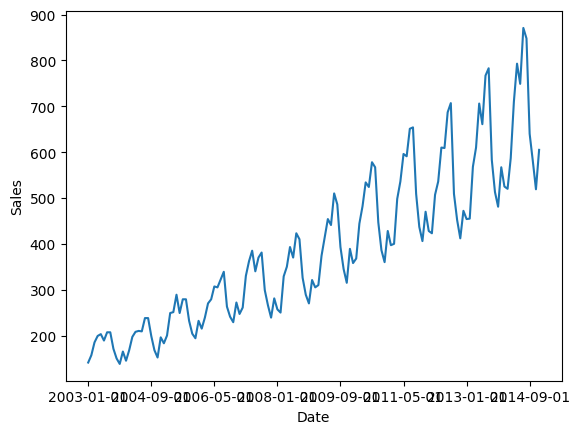

In [6]:
# Plot the time series
# Is this time series stationary?
import matplotlib.pylab as plt
ax = sales_ts.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

In [7]:
# Dickey-Fuller Test to verify whether a time-series is stationary
# Null hypothesis: Series is non-stationary
# p-vlaue: non-significance indicating non-stationary
# Test Statistic > Critical Value: Reject null hypothesis and conclude Series is stationary

from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
dftest = adfuller(sales_ts.values[1:],autolag='AIC')
dfoutput = pd.Series(dftest[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in dftest[4].items(): dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                   1.050642
p-value                          0.994773
#lags used                      14.000000
Number of observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


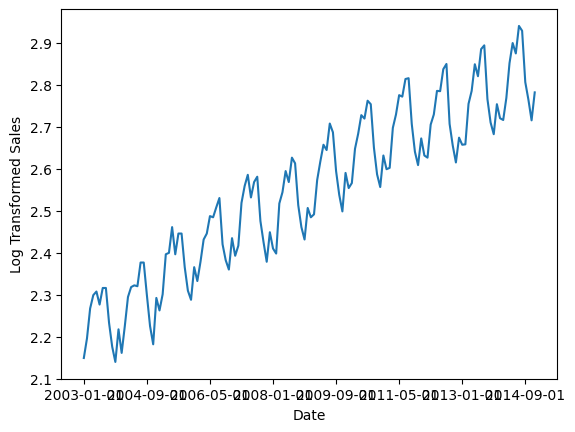

In [8]:
# Log transformation to achieve constant variance
import numpy as np
sales_ts_log = np.log10(sales_ts)
ax = sales_ts_log.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Sales')
plt.show()

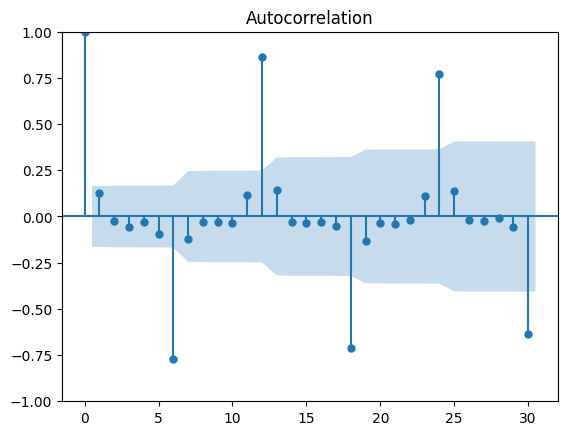

In [9]:
# Plot ACF to check potential seasonality
# ACF: autocorrelation factor
import statsmodels.tsa.api as smt
sales_ts_log_diff = sales_ts_log.diff(periods= 1)
sales_ts_log_diff.dropna(inplace=True)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

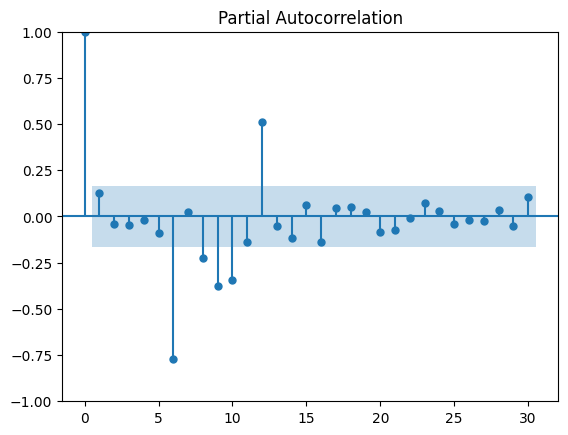

In [10]:
# Partial ACF plot to show significant lags
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, alpha= 0.05)
plt.show()

In [11]:
# Data partition for the time series data
# Keep the last three years data as the validation dataset
nValid = 36
nTrain = len(sales_ts_log) - nValid
train_ts = sales_ts_log[:nTrain]
valid_ts = sales_ts_log[nTrain:]

In [12]:
# Test a SARIMA model
import statsmodels.api as sm
temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(1,1,1),
                                       seasonal_order=(1,0,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
results = temp_model.fit()
print(results.summary())

/Users/jakebrulato/Documents/GitHub/Advanced_BA/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/jakebrulato/Documents/GitHub/Advanced_BA/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79197D+00    |proj g|=  1.58310D+01

At iterate    5    f= -2.42034D+00    |proj g|=  2.07535D+00

At iterate   10    f= -2.47335D+00    |proj g|=  1.21315D+01

At iterate   15    f= -2.48555D+00    |proj g|=  2.36993D-01

At iterate   20    f= -2.48726D+00    |proj g|=  3.84523D+00

At iterate   25    f= -2.49304D+00    |proj g|=  2.71479D-02

At iterate   30    f= -2.49307D+00    |proj g|=  1.47717D-01

At iterate   35    f= -2.49650D+00    |proj g|=  3.66366D+00

At iterate   40    f= -2.51306D+00    |proj g|=  4.19715D-01

At iterate   45    f= -2.51308D+00    |proj g|=  1.78050D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [13]:
# forecast with the fitted model
pred = results.get_forecast(steps=36,alpha=0.05)

# Get the forecasted values
forecasted_values = pred.predicted_mean

# Get the confidence intervals for the forecasted values
confidence_intervals = pred.conf_int()

# Print the forecasted values
print("Forecasted values:")
print(forecasted_values)

# Print the confidence intervals
print("\n95% confidence intervals:")
print(confidence_intervals)

Forecasted values:
2012-01-01    2.643508
2012-02-01    2.650237
2012-03-01    2.739924
2012-04-01    2.772474
2012-05-01    2.815417
2012-06-01    2.803896
2012-07-01    2.849101
2012-08-01    2.845130
2012-09-01    2.743783
2012-10-01    2.683509
2012-11-01    2.651233
2012-12-01    2.722891
2013-01-01    2.692092
2013-02-01    2.699795
2013-03-01    2.788416
2013-04-01    2.820920
2013-05-01    2.863481
2013-06-01    2.852075
2013-07-01    2.896947
2013-08-01    2.893009
2013-09-01    2.792376
2013-10-01    2.732528
2013-11-01    2.700480
2013-12-01    2.771632
2014-01-01    2.741051
2014-02-01    2.748699
2014-03-01    2.836695
2014-04-01    2.868968
2014-05-01    2.911229
2014-06-01    2.899903
2014-07-01    2.944458
2014-08-01    2.940549
2014-09-01    2.840626
2014-10-01    2.781201
2014-11-01    2.749379
2014-12-01    2.820029
Freq: MS, Name: predicted_mean, dtype: float64

95% confidence intervals:
            lower Sales  upper Sales
2012-01-01     2.611662     2.675354
2012-

/Users/jakebrulato/Documents/GitHub/Advanced_BA/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [14]:
# Search for best parameters for SARIMA
# generate the parameter combinations
# Define the p, d and q parameters to take any value between 0 and 2
import itertools

p = d = q = range(0,2)

# Generate all possible combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all possible combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

print(pdq)
print(seasonal_pdq)


[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [15]:
import sys
# Specify to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
print("Start search time:", datetime.now())

# Set up the initial values
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

import statsmodels.api as sm
# Using loops to search for the best SARIMA model
# Choose the best SARIMA model based on minimum AIC values
# AIC: to balance the model between goodness-of-fit and number of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = temp_model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

print("End search time:", datetime.now())

Start search time: 2024-04-09 18:05:44.509985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32752D+00    |proj g|=  1.62483D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.625D-06   2.328D+00
  F =   2.3275188725774010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.81683D+00    |proj g|=  1.80646D-04

At iterate   30    f=  1.81683D+00    |proj g|=  4.55251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     33     40      1     0     0   4.320D-06   1.817D+00
  F =   1.8168286294102911     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.18822D+00    |proj g|=  1.85765D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28685D+03    |proj g|=  3.20094D+05

At iterate    5    f=  1.58376D+00    |proj g|=  5.55458D-01

At iterate   10    f=  1.46655D-01    |proj g|=  9.81849D-01

At iterate   15    f= -6.81104D-01    |proj g|=  5.58133D+00

At iterate   20    f= -9.26156D-01    |proj g|=  1.57051D-01

At iterate   25    f= -9.32763D-01    |proj g|=  2.45771D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26    105      3     0     0   2.487D-03  -9.328D-01
  F = -0.93276335115941877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59646D+04    |proj g|=  1.36780D+06

At iterate    5    f=  1.90472D+00    |proj g|=  1.37660D+00

At iterate   10    f= -2.09938D-01    |proj g|=  2.43949D-01

At iterate   15    f= -7.54203D-01    |proj g|=  3.69797D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.28724D+00    |proj g|=  5.32541D-01

At iterate   10    f= -1.59877D+00    |proj g|=  4.78302D-01

At iterate   15    f= -1.59909D+00    |proj g|=  5.08117D-01

At iterate   20    f= -1.61775D+00    |proj g|=  4.42657D+00

At iterate   25    f= -1.70225D+00    |proj g|=  7.77222D-01

At iterate   30    f= -1.72115D+00    |proj g|=  4.90895D-01

At iterate   35    f= -1.72763D+00    |proj g|=  1.40065D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     54      1     0     0   3.235D-01  -1.728D+00
  F =  -1.7281107437165559     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03259D+00    |proj g|=  3.54541D-01

At iterate    5    f=  1.16772D+00    |proj g|=  2.20715D-02

At iterate   10    f=  1.14780D+00    |proj g|=  7.29001D-03

At iterate   15    f=  1.14625D+00    |proj g|=  2.99653D-03

At iterate   20    f=  1.14603D+00    |proj g|=  9.61003D-04

At iterate   25    f=  1.14601D+00    |proj g|=  2.71158D-04

At iterate   30    f=  1.14601D+00    |proj g|=  1.08911D-04

At iterate   35    f=  1.14601D+00    |proj g|=  6.12245D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.62850D+00    |proj g|=  6.84618D-02

At iterate   15    f= -1.63041D+00    |proj g|=  4.18943D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     25      1     0     0   4.343D-03  -1.630D+00
  F =  -1.6304117228500137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.03259D+00    |proj g|=  3.54548D-01

At iterate    5    f= -4.45288D-01    |proj g|=  4.01614D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     38      1     0     0   7.525D-05  -1.273D+00
  F =  -1.2734477750040070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41090D+00    |proj g|=  1.13720D+00

At iterate    5    f= -1.72752D-01    |proj g|=  8.45108D+00

At iterate   10    f= -1.02518D+00    |proj g|=  3.08668D+00

At iterate   15    f= -1.06946D+00    |proj g|=  4.02836D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.44114D+00    |proj g|=  9.46476D+00

At iterate    5    f= -1.65848D+00    |proj g|=  4.50300D-01

At iterate   10    f= -1.69700D+00    |proj g|=  1.41847D-01

At iterate   15    f= -1.70338D+00    |proj g|=  1.31164D+00

At iterate   20    f= -1.70776D+00    |proj g|=  2.68252D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     76      2     0     0   5.597D-04  -1.708D+00
  F =  -1.7077590313094704     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46424D+00    |proj g|=  8.70758D+00

At iterate    5    f= -1.62589D+00    |proj g|=  2.24725D+00

At iterate   10    f= -1.75952D+00    |proj g|=  2.05488D+00

At iterate   15    f= -1.79052D+00    |proj g|=  1.72294D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.73691D+00    |proj g|=  8.69454D-01

At iterate   10    f= -1.80512D+00    |proj g|=  4.33052D+00

At iterate   15    f= -1.82317D+00    |proj g|=  8.56906D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     18     27      1     0     0   6.221D-05  -1.823D+00
  F =  -1.8231792919929648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.16267D+00    |proj g|=  6.21261D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.45241D+00    |proj g|=  1.78219D-01

At iterate   10    f= -2.45386D+00    |proj g|=  3.21672D+00

At iterate   15    f= -2.45670D+00    |proj g|=  1.76871D-02

At iterate   20    f= -2.45683D+00    |proj g|=  2.84360D-01

At iterate   25    f= -2.46652D+00    |proj g|=  5.31125D+00

At iterate   30    f= -2.47174D+00    |proj g|=  9.41239D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     50      1     0     0   1.621D-02  -2.472D+00
  F =  -2.4717443638011525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f= -2.25934D+00    |proj g|=  4.82329D-01
  ys=-6.360E-10  -gs= 1.742E-09 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     29      1     1     0   2.984D-02  -2.259D+00
  F =  -2.2593680501315165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.25335D+00    |proj g|=  1.86975D+01

At iterate    5    f= -2.27353D+00    |proj g|=  7.47171D-01

At iterate   10  

 This problem is unconstrained.



At iterate   20    f= -2.30184D+00    |proj g|=  1.64709D+00

At iterate   25    f= -2.30265D+00    |proj g|=  4.92682D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   3.482D-02  -2.303D+00
  F =  -2.3026497174883067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.47018D+00    |proj g|=  2.83421D-01

At iterate    5    f= -1.47027D+00    |proj g|=  1.44313D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -1.74054D+00    |proj g|=  9.15675D-01

At iterate   10    f= -1.80854D+00    |proj g|=  3.88009D+00

At iterate   15    f= -1.82410D+00    |proj g|=  1.20080D-02

At iterate   20    f= -1.82413D+00    |proj g|=  1.02254D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     29      1     0     0   1.043D-04  -1.824D+00
  F =  -1.8241479554205882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     54      2     0     0   5.120D-03  -2.228D+00
  F =  -2.2276163052809248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32048D+00    |proj g|=  1.28764D+01

At iterate    5    f= -2.34339D+00    |proj g|=  1.34026D-01

At iterate   10    f= -2.35031D+00    |proj g|=  5.90788D+00

At iterate   15    f= -2.35836D+00    |proj g|=  3.36423D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.35849D+00    |proj g|=  6.36712D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-5.571E-11  -gs= 3.121E-10 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32    126      4     1     0   7.380D-03  -2.358D+00
  F =  -2.3584888017441297     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76901D+00    |proj g|=  1.53759D+01

At iterate    5    f= -2.31197D+00    |proj g|=  4.00464D-01

At iterate   10    f= -2.32918D+00    |proj g|=  1.22795D+01

At iterate   15  


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     48      1     0     0   2.510D-03  -2.394D+00
  F =  -2.3940058664709944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79208D+00    |proj g|=  1.58363D+01

At iterate    5    f= -2.42139D+00    |proj g|=  1.49856D+00

At iterate   10    f= -2.46309D+00    |proj g|=  1.58358D+01


 This problem is unconstrained.



At iterate   15    f= -2.48995D+00    |proj g|=  8.76937D-02

At iterate   20    f= -2.49063D+00    |proj g|=  2.26290D+00

At iterate   25    f= -2.49374D+00    |proj g|=  4.09796D-01

At iterate   30    f= -2.49379D+00    |proj g|=  1.45279D-01

At iterate   35    f= -2.49539D+00    |proj g|=  4.68786D-02

At iterate   40    f= -2.51459D+00    |proj g|=  1.88930D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     66      1     0     0   1.321D-02  -2.515D+00
  F =  -2.5150223902205431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30949D+00    |proj g|=  1.19642D+01

At iterate    5    f= -2.32887D+00    |proj g|=  5.46312D-02

At iterate   10    f= -2.32925D+00    |proj g|=  4.97606D-02

At iterate   15    f= -2.33174D+00    |proj g|=  4.25076D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     83      3     0     0   4.125D-03  -2.332D+00
  F =  -2.3317447195138397     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31678D+00    |proj g|=  1.23892D+01

At iterate    5    f= -2.33795D+00    |proj g|=  9.51126D-01

At iterate   10    f= -2.34897D+00    |proj g|=  6.50356D+00

At iterate   15    f= -2.35263D+00    |proj g|=  5.40608D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f= -1.09734D+00    |proj g|=  1.34479D+00

At iterate   15    f= -1.70267D+00    |proj g|=  8.47124D+00

At iterate   20    f= -1.78643D+00    |proj g|=  6.99655D-01

At iterate   25    f= -1.79445D+00    |proj g|=  8.88473D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     86      2     1     0   1.177D-04  -1.794D+00
  F =  -1.7944916350507532     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.19398D+00    |proj g|=  4.61117D-01

At iterate    5    f= -2.19400D+00    |proj g|=  6.95958D-03
  ys=-5.314E-13  -gs= 1.101E-11 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.



At iterate    5    f= -2.15461D+00    |proj g|=  2.40386D+00

At iterate   10    f= -2.25380D+00    |proj g|=  2.02536D+01

At iterate   15    f= -2.28772D+00    |proj g|=  1.63976D-01

At iterate   20    f= -2.28774D+00    |proj g|=  3.02829D-01

At iterate   25    f= -2.28798D+00    |proj g|=  1.58309D-01

At iterate   30    f= -2.30171D+00    |proj g|=  3.08135D+00

At iterate   35    f= -2.30720D+00    |proj g|=  7.54384D+00

At iterate   40    f= -2.31695D+00    |proj g|=  1.32431D+00

At iterate   45    f= -2.31739D+00    |proj g|=  1.16975D+00

At iterate   50    f= -2.31758D+00    |proj g|=  1.46923D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -2.31733D+00    |proj g|=  1.81883D-01

At iterate   30    f= -2.32402D+00    |proj g|=  4.48913D+00

At iterate   35    f= -2.33194D+00    |proj g|=  2.74551D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     58      1     1     0   9.991D-03  -2.332D+00
  F =  -2.3319392019428626     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85943D+03    |proj g|=  1.03786D+05

At iter

 This problem is unconstrained.



At iterate   10    f= -1.81871D+00    |proj g|=  1.26728D+01

At iterate   15    f= -2.27084D+00    |proj g|=  1.02030D-01

At iterate   20    f= -2.27093D+00    |proj g|=  2.26818D-01

At iterate   25    f= -2.27137D+00    |proj g|=  1.57198D+00

At iterate   30    f= -2.27438D+00    |proj g|=  6.15454D+00

At iterate   35    f= -2.27880D+00    |proj g|=  1.15359D+00

At iterate   40    f= -2.27946D+00    |proj g|=  1.23710D-01

At iterate   45    f= -2.27948D+00    |proj g|=  1.57682D-01

At iterate   50    f= -2.27948D+00    |proj g|=  3.11540D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50    102   

 This problem is unconstrained.



At iterate   15    f= -2.24665D+00    |proj g|=  6.79000D-01

At iterate   20    f= -2.26741D+00    |proj g|=  1.10377D+01

At iterate   25    f= -2.31325D+00    |proj g|=  5.30858D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -2.31336D+00    |proj g|=  2.15985D-01

At iterate   35    f= -2.31365D+00    |proj g|=  1.39929D-01
  ys=-8.702E-06  -gs= 1.956E-06 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40    152      4     1     0   1.321D-02  -2.314D+00
  F =  -2.3136831128671180     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24017D+02    |proj g|=  3.00325D+04

At iterate    5    f=  1.35358D+00    |proj g|=  4.86692D-01

At iterate   10    f= -8.98277D-01    |proj g|=  4.69903D-01

At iterate   15    f= -1.36971D+00    |proj g|=  1.62069D+00

At iter


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.503E+00  -gs= 1.035E+00 BFGS update SKIPPED

At iterate   10    f= -1.22861D+00    |proj g|=  1.06897D+00

At iterate   15    f= -1.33877D+00    |proj g|=  3.05807D-01

At iterate   20    f= -1.77604D+00    |proj g|=  4.24365D-01

At iterate   25    f= -1.79449D+00    |proj g|=  3.12813D-02

At iterate   30    f= -1.79500D+00    |proj g|=  2.83229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     58      1     1     0   1.588D-05  -1.795D+00
  F =  -1.7949975325960226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -2.24017D+00    |proj g|=  1.80131D+01

At iterate   10    f= -2.35405D+00    |proj g|=  8.31403D-02

At iterate   15    f= -2.35717D+00    |proj g|=  7.96653D-02

At iterate   20    f= -2.35726D+00    |proj g|=  1.11046D-01

At iterate   25    f= -2.35727D+00    |proj g|=  1.48384D-01

At iterate   30    f= -2.35732D+00    |proj g|=  1.05022D+00

At iterate   35    f= -2.35809D+00    |proj g|=  7.14030D-02

At iterate   40    f= -2.35861D+00    |proj g|=  1.21396D+00

At iterate   45    f= -2.36163D+00    |proj g|=  1.62555D+00

At iterate   50    f= -2.37183D+00    |proj g|=  2.50597D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24017D+02    |proj g|=  3.00325D+04

At iterate    5    f=  1.28240D+00    |proj g|=  5.59210D-01

At iterate   10    f= -1.70153D+00    |proj g|=  1.61109D+00

At iterate   15    f= -2.12707D+00    |proj g|=  1.93856D+01

At iterate   20    f= -2.35814D+00    |proj g|=  1.99987D-01

At iterate   25    f= -2.35941D+00    |proj g|=  1.58496D-02

At iterate   30    f= -2.36054D+00    |proj g|=  3.04907D+00

At iterate   35    f= -2.37433D+00    |proj g|=  2.77023D-01

At iterate   40    f= -2.37512D+00    |proj g|=  5.61605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f= -1.56476D+00    |proj g|=  4.56025D-01

At iterate   15    f= -2.09532D+00    |proj g|=  3.88263D+00

At iterate   20    f= -2.11528D+00    |proj g|=  1.76369D+00

At iterate   25    f= -2.31839D+00    |proj g|=  4.67456D-01

At iterate   30    f= -2.49847D+00    |proj g|=  1.22738D+00

At iterate   35    f= -2.49861D+00    |proj g|=  1.83656D-01

At iterate   40    f= -2.49863D+00    |proj g|=  6.81752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     74      1     0     0   6.854D-04  -2.499D+00
  F =  -2.4986322290550600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f= -2.30324D+00    |proj g|=  1.06466D+01

At iterate   20    f= -2.31449D+00    |proj g|=  2.24045D+00

At iterate   25    f= -2.34282D+00    |proj g|=  1.66629D-01

At iterate   30    f= -2.34284D+00    |proj g|=  3.88945D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     99      2     0     0   3.889D-02  -2.343D+00
  F =  -2.3428398898858727     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22333D+00    |proj g|=  1.89983D-01

At iterate    5    f= -2.23932D+00    |proj g|=  1.10517D+01

At iterate   10    f= -2.29365D+00    |proj g|=  1.12985D-01

At iterate   15    f= -2.30983D+00    |proj g|=  2.37397D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2     45      2     0     0   1.246D-02  -2.224D+00
  F =  -2.2235949015998120     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.32237D+00    |proj g|=  1.14415D+01

At iterate    5    f= -2.33916D+00    |proj g|=  1.89675D-01

At iterate   10    f= -2.34274D+00    |proj g|=  5.37601D+00

At iterate   15    f= -2.35408D+00    |proj g|=  9.83111D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f= -2.35416D+00    |proj g|=  3.75221D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     55      1     0     0   3.752D-02  -2.354D+00
  F =  -2.3541574415420237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.77399D+00    |proj g|=  1.54267D+01

At iterate    5    f= -2.30977D+00    |proj g|=  1.17659D+00

At iterate   10    f= -2.38982D+00    |proj g|=  5.14823D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     77      2     0     0   1.670D-03  -2.393D+00
  F =  -2.3932789227768754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79731D+00    |proj g|=  1.58989D+01

At iterate    5    f= -2.41878D+00    |proj g|=  1.60209D+00

At iterate   10    f= -2.47815D+00    |proj g|=  1.24950D+01

At iterate   15    f= -2.48985D+00    |proj g|=  2.36477D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     63      2     0     0   1.662D-02  -2.325D+00
  F =  -2.3245454304512174     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31812D+00    |proj g|=  1.08845D+01

At iterate    5    f= -2.33316D+00    |proj g|=  2.19910D-01

At iterate   10    f= -2.34294D+00    |proj g|=  5.94015D+00

At iterate   15    f= -2.34617D+00    |proj g|=  1.24826D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -1.82401D+00    |proj g|=  2.48094D-03

At iterate   25    f= -1.82414D+00    |proj g|=  1.93575D-01

At iterate   30    f= -1.82416D+00    |proj g|=  9.98842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     50      1     0     0   9.988D-04  -1.824D+00
  F =  -1.8241592311490504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.22355D+00    |proj g|=  1.41565D+00
  ys=-1.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31944D+00    |proj g|=  1.22383D+01

At iterate    5    f= -2.33958D+00    |proj g|=  4.30369D-01

At iterate   10    f= -2.34872D+00    |proj g|=  6.86780D+00

At iterate   15    f= -2.35428D+00    |proj g|=  4.22932D-02

At iterate   20    f= -2.35451D+00    |proj g|=  8.97860D-03

At iterate   25    f= -2.35598D+00    |proj g|=  2.01702D+00

At iterate   30    f= -2.35743D+00    |proj g|=  1.26675D+00

At iterate   35    f= -2.36026D+00    |proj g|=  2.01076D+00

At iterate   40    f= -2.36070D+00    |proj g|=  1.53489D-01
  ys=-1.206E-09  -gs= 3.711E-09 BFGS update SKIPPED

At iterate   45    f= -2.36071D+00    |proj g|=  6.95435D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     93      1     1     0   4.931D-02  -2.361D+00
  F =  -2.3607161043886817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.76877D+00    |proj g|=  1.53658D+01

At iterate    5    f= -2.31087D+00    |proj g|=  4.23794D-01

At iterate   10    f= -2.37426D+00    |proj g|=  1.07669D+01

At iterate   15    f= -2.39288D+00    |proj g|=  5.14275D-03

At iter

 This problem is unconstrained.



At iterate   10    f= -2.47335D+00    |proj g|=  1.21315D+01

At iterate   15    f= -2.48555D+00    |proj g|=  2.36993D-01

At iterate   20    f= -2.48726D+00    |proj g|=  3.84523D+00

At iterate   25    f= -2.49304D+00    |proj g|=  2.71479D-02

At iterate   30    f= -2.49307D+00    |proj g|=  1.47717D-01

At iterate   35    f= -2.49650D+00    |proj g|=  3.66366D+00

At iterate   40    f= -2.51306D+00    |proj g|=  4.19715D-01

At iterate   45    f= -2.51308D+00    |proj g|=  1.78050D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     70      1     0     0   1.780D-01  -2.513D+00
  F =  -2.51307763300

 This problem is unconstrained.



At iterate    5    f= -2.32491D+00    |proj g|=  8.81920D-02

At iterate   10    f= -2.32512D+00    |proj g|=  1.10044D+00

At iterate   15    f= -2.32555D+00    |proj g|=  1.33901D-02

At iterate   20    f= -2.32584D+00    |proj g|=  5.30733D-01

At iterate   25    f= -2.32599D+00    |proj g|=  1.40162D-01

At iterate   30    f= -2.32707D+00    |proj g|=  6.44863D-01

At iterate   35    f= -2.33069D+00    |proj g|=  2.40316D+00

At iterate   40    f= -2.33209D+00    |proj g|=  1.53208D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43    101      2     0     0   2.977D-02  -2.332D+00
  F =  -2.3320935129623703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.31545D+00    |proj g|=  1.17162D+01

At iterate    5    f= -2.33377D+00    |proj g|=  4.38251D-01

At iterate   10    f= -2.33900D+00    |proj g|=  6.59036D+00

At iterate   15    f= -2.34691D+00    |proj g|=  7.25244D-02

At iter

In [16]:
# run best model
best_model = sm.tsa.statespace.SARIMAX(train_ts,
                                       order=(0,1,1),
                                       seasonal_order=(1,0,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
best_results = best_model.fit()

print(best_results.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79208D+00    |proj g|=  1.58363D+01

At iterate    5    f= -2.42139D+00    |proj g|=  1.49856D+00

At iterate   10    f= -2.46309D+00    |proj g|=  1.58358D+01


 This problem is unconstrained.



At iterate   15    f= -2.48995D+00    |proj g|=  8.76937D-02

At iterate   20    f= -2.49063D+00    |proj g|=  2.26290D+00

At iterate   25    f= -2.49374D+00    |proj g|=  4.09796D-01

At iterate   30    f= -2.49379D+00    |proj g|=  1.45279D-01

At iterate   35    f= -2.49539D+00    |proj g|=  4.68786D-02

At iterate   40    f= -2.51459D+00    |proj g|=  1.88930D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     66      1     0     0   1.321D-02  -2.515D+00
  F =  -2.5150223902205431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Result

In [17]:
!pip install dmba

In [18]:
# !pip install dmba
# after installing the above library, you can comment the above line for subsequent code runs

from dmba import regressionSummary
regressionSummary(np.power(10,valid_ts),
                  np.power(10,pred.predicted_mean))

no display found. Using non-interactive Agg backend

Regression statistics

                      Mean Error (ME) : -34.5416
       Root Mean Squared Error (RMSE) : 39.4143
            Mean Absolute Error (MAE) : 35.0030
          Mean Percentage Error (MPE) : -6.1819
Mean Absolute Percentage Error (MAPE) : 6.2461


In [19]:
pred = best_results.get_forecast(steps=36,alpha=0.05)

# Get the forecasted values
forecasted_values = pred.predicted_mean

# Get the confidence intervals for the forecasted values
confidence_intervals = pred.conf_int()

# Print the forecasted values
print("Forecasted values:")
print(forecasted_values)

# Print the confidence intervals
print("\n95% confidence intervals:")
print(confidence_intervals)

Forecasted values:
2012-01-01    2.644401
2012-02-01    2.652851
2012-03-01    2.741920
2012-04-01    2.774833
2012-05-01    2.817714
2012-06-01    2.806275
2012-07-01    2.851507
2012-08-01    2.847540
2012-09-01    2.746041
2012-10-01    2.685671
2012-11-01    2.653358
2012-12-01    2.725079
2013-01-01    2.694622
2013-02-01    2.703016
2013-03-01    2.791499
2013-04-01    2.824197
2013-05-01    2.866795
2013-06-01    2.855432
2013-07-01    2.900366
2013-08-01    2.896426
2013-09-01    2.795593
2013-10-01    2.735620
2013-11-01    2.703520
2013-12-01    2.774770
2014-01-01    2.744513
2014-02-01    2.752852
2014-03-01    2.840753
2014-04-01    2.873235
2014-05-01    2.915553
2014-06-01    2.904265
2014-07-01    2.948904
2014-08-01    2.944989
2014-09-01    2.844820
2014-10-01    2.785242
2014-11-01    2.753353
2014-12-01    2.824133
Freq: MS, Name: predicted_mean, dtype: float64

95% confidence intervals:
            lower Sales  upper Sales
2012-01-01     2.612801     2.676001
2012-

In [20]:
ax = pred.predicted_mean.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Log Transformed Sales')
plt.show()